In [1]:
# ####### Install necessary libraries ####### #
!pip install pandas

In [2]:
# ####### Import libraries ####### #
import pandas as pd
import gspread
from gspread_dataframe import get_as_dataframe
from google.colab import auth
from googleapiclient.discovery import build
import os
import geopandas as gpd
from shapely.geometry import Point
import random

In [3]:
# ### First we need to get the data we want to use.
# I have a spreadsheet where I've combined the state house
# and the state senators titled 'UTsTateLegIslaTurE_02122025.xlsx'
# Next we need to output the file into a json format so I can use
# javascript to build the webpage.

# ####### Mount Google Drive to Colab ####### #
from google.colab import drive
drive.mount('/content/drive')

# ####### Authenticate
auth.authenticate_user()

from google.auth import default
creds, _ = default()
gc = gspread.authorize(creds)
drive_service = build('drive', 'v3', credentials=creds)

# function to loop through google drive folder and make a list of file id's
def get_sheet_urls_from_folder(folder_id):
    query = f"'{folder_id}' in parents and mimeType='application/vnd.google-apps.spreadsheet'"
    results = drive_service.files().list(q=query, fields="files(id, name)").execute()
    files = results.get('files', [])
    return [f"https://docs.google.com/spreadsheets/d/{file['id']}" for file in files]

# Get the URLs of each Google Sheet
sheet_urls_1 = get_sheet_urls_from_folder('1NKiEF5Mq5FD6DSxSJfuXXw7RH_8baZXv')

def read_google_sheet(sheet_url, worksheet_name=None):
    # Open the Google Sheet by its URL
    sheet = gc.open_by_url(sheet_url)
    # Select the worksheet
    if worksheet_name:
        worksheet = sheet.worksheet(worksheet_name)
    else:
        worksheet = sheet.get_worksheet(0)  # Default to the first sheet

    # Convert the worksheet to a DataFrame
    df = get_as_dataframe(worksheet, evaluate_formulas=True).dropna(how='all')  # Drop rows that are completely empty
    df['sheet_name'] = sheet.title  # Add a column with the sheet name
    return df

# There's a weird warning about the format and openpyxl but we don't gotta worry about that so ignore it
import warnings
warnings.simplefilter("ignore")

all_data = []

for url in sheet_urls_1:
    try:
        df = read_google_sheet(url)
        all_data.append(df)
    except Exception as e:
        print(f"Could not read {url}: {e}")

reps = pd.concat(all_data, ignore_index=True)

# Check data
# print(reps.head())
print(reps.info())

Mounted at /content/drive
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 11 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   District                       104 non-null    float64
 1   Office                         104 non-null    object 
 2   Representative                 104 non-null    object 
 3   Webpage                        104 non-null    object 
 4   Img_ID                         104 non-null    object 
 5   Img_URL                        104 non-null    object 
 6   Legislation_By_Representative  104 non-null    object 
 7   Party                          104 non-null    object 
 8   Email                          104 non-null    object 
 9   County(ies)                    104 non-null    object 
 10  sheet_name                     104 non-null    object 
dtypes: float64(1), object(10)
memory usage: 9.1+ KB
None


In [4]:
# Clean Data

# Split name into 3 columns
reps[['Last_Name', 'First_Name', 'Middle_Name']] = reps['Representative'].str.split(' ', n=2, expand=True)

# remove comma from the end of the last name
reps['Last_Name'] = reps['Last_Name'].str.rstrip(',')

# remove period from the end of the middle name
reps['Middle_Name'] = reps['Middle_Name'].apply(lambda x: x.rstrip('.') if isinstance(x, str) else x)

# Combine name in correct order
reps['Rep_Name'] = reps['First_Name'] + ' ' + reps['Middle_Name'].fillna('') + ' ' + reps['Last_Name']
reps['Rep_Name'] = reps['Rep_Name'].str.replace(r'\s+', ' ', regex=True)  # Remove multiple spaces

# convert district from float to int
reps['District'] = reps['District'].astype(int)

# convert district from int to string
reps['District'] = reps['District'].astype(str)

# we are going to match reps with the bills that they have passed
# so adding a column Bill Sponsor to make matching easier

reps['Bill Sponsor'] = reps['Rep_Name'].apply(lambda name: f"{name.split()[-1]}, {name[0]}.")

# rearrage columns and remove sheet name from df
reps = reps[['Img_ID', 'Office', 'Rep_Name', 'District',
      'Party', 'Email', 'County(ies)', 'Webpage', 'Img_URL',
       'Legislation_By_Representative', 'Bill Sponsor']].copy().reset_index(drop=True)


In [ ]:
# save data as a json file in google drive

print('\n', 'Saving current officials to json file')
file_path = '/content/drive/My Drive/ElectionTime/data/'
save_filename = 'reps.json'
reps.to_json(file_path + save_filename, index=False, orient='records')
print('Script Completed')


 Saving current officials to json file
Script Completed


In [5]:
# Now that we have the reps info we need to pull in the bills
# I have found two types of data
# on the state leg website there is a downloadable csv with bills that have been passed
# There is also a html table that I copied and pasted to a google sheet with new bills
# Will need to read in data from both so .read_csv and looping through a googledrive folder

# Get the URLs of each Google Sheet
sheet_urls_2 = get_sheet_urls_from_folder('14hEphuFcwv3cfRYSldVVgUjb1ihm8DjO')

all_data = []

for url in sheet_urls_2:
    try:
        df = read_google_sheet(url)
        all_data.append(df)
    except Exception as e:
        print(f"Could not read {url}: {e}")

new_bills = pd.concat(all_data, ignore_index=True)

In [7]:
new_bills.head()

,Bill Number,Link to Bill,Short Title,Sponsor,Date Numbered,Office,First Initial,Middle,Last Name,sheet_name
0,HB0509,https://le.utah.gov/~2025/bills/static/HB0509....,Kratom Amendments,"Rep. Dailey-Provost, J.",2/14/2025,State House,J,NaN,Dailey-Provost,new_bills_02142025
1,SB0282,https://le.utah.gov/~2025/bills/static/SB0282....,Higher Education Hiring Amendments,"Sen. Wilson, C.",2/14/2025,State Senate,C,NaN,Wilson,new_bills_02142025
2,HB0508,https://le.utah.gov/~2025/bills/static/HB0508....,School Data Amendments,"Rep. MacPherson, M.",2/14/2025,State House,M,NaN,MacPherson,new_bills_02142025
3,SB0281,https://le.utah.gov/~2025/bills/static/SB0281....,Corporal Punishment in Schools Amendments,"Sen. Grover, K.",2/14/2025,State Senate,K,NaN,Grover,new_bills_02142025
4,HB0507,https://le.utah.gov/~2025/bills/static/HB0507....,Legislative Water Development Commission Amend...,"Rep. Peterson, T.",2/14/2025,State House,T,NaN,Peterson,new_bills_02142025


In [8]:
new_bills.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Bill Number    90 non-null     object
 1   Link to Bill   90 non-null     object
 2   Short Title    90 non-null     object
 3   Sponsor        90 non-null     object
 4   Date Numbered  90 non-null     object
 5   Office         90 non-null     object
 6   First Initial  90 non-null     object
 7   Middle         11 non-null     object
 8   Last Name      90 non-null     object
 9   sheet_name     90 non-null     object
dtypes: object(10)
memory usage: 7.2+ KB


In [9]:
# Clean Data

# format date numbered column as a data
new_bills['Date Numbered'] = pd.to_datetime(new_bills['Date Numbered'], format='%m/%d/%Y')
# remove the 'Rep' or 'Sen' from the sponsor field
new_bills['Bill Sponsor'] = new_bills['Sponsor'].str.lstrip('Rep. Sen. ')

# format as lastname first initial to match the format of passed_bills dataframe
new_bills['Bill Sponsor'] = new_bills['Bill Sponsor'].str.replace(r'(\w+)-(\w+), (\w)\.', r'\1-\2, \3.', regex=True)

In [10]:
# Read the csv's of the passed bills downloaded from the state legislative website
def read_csv_files(file_path, extension='.csv'):
    files = [x for x in os.listdir(file_path) if x.endswith(extension)]
    all_data = []
    for filename in files:
        try:
            df = pd.read_csv(file_path + filename)
            df['filename'] = filename
            all_data.append(df)
        except Exception as e:
            print(f"Could not read {filename}: {e}")
    return pd.concat(all_data, ignore_index=True)


# ####### Set the file path to uploaded csv file ####### #
file_path = '/content/drive/My Drive/ElectionTime/data/bills/'

# ####### Read the Excel file into a DataFrame ####### #
print("\n", "Reading csv file...")
passed_bills = read_csv_files(file_path)

#check data
passed_bills.head()


 Reading csv file...


,Bill Number,Bill Title,Bill Sponsor,Date Passed,Effective Date,Governor's Action,Gov's Action Date,Laws of Utah Chapter,filename
0,HB0001,Higher Education Base Budget,"Peterson, K.",1/30/2025,7/1/2025,NaN,NaN,NaN,passedBills_02142025.csv
1,HB0004,Economic and Community Development Base Budget,"Watkins, C.",1/30/2025,7/1/2025,NaN,NaN,NaN,passedBills_02142025.csv
2,HB0005,General Government Base Budget,"Thurston, N.",1/30/2025,7/1/2025,NaN,NaN,NaN,passedBills_02142025.csv
3,HB0006,Transportation and Infrastructure Base Budget,"Welton, D.",1/30/2025,7/1/2025,NaN,NaN,NaN,passedBills_02142025.csv
4,HB0007,"National Guard, Veterans Affairs, and Legislat...","Peterson, V.",1/30/2025,7/1/2025,NaN,NaN,NaN,passedBills_02142025.csv


In [11]:
passed_bills.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1066 entries, 0 to 1065
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Bill Number           1066 non-null   object 
 1   Bill Title            1066 non-null   object 
 2   Bill Sponsor          1066 non-null   object 
 3   Date Passed           1066 non-null   object 
 4   Effective Date        852 non-null    object 
 5   Governor's Action     69 non-null     object 
 6   Gov's Action Date     69 non-null     object 
 7   Laws of Utah Chapter  60 non-null     float64
 8   filename              1066 non-null   object 
dtypes: float64(1), object(8)
memory usage: 75.1+ KB


In [12]:
# Clean Data

# Extract file date from the filename
passed_bills['file_date'] = [x.split('.')[0].split('_')[1] for x in passed_bills['filename']]
passed_bills['file_date'] = pd.to_datetime(passed_bills['file_date'], format='%m%d%Y')

# What to do about empty dates?


# Change Date Passed and Effective Date to dates
passed_bills['Date Passed'] = pd.to_datetime(passed_bills['Date Passed'], format='%m/%d/%Y', errors='coerce')
passed_bills['Effective Date'] = pd.to_datetime(passed_bills['Effective Date'], format='%m/%d/%Y', errors='coerce')

# drop duplicates
print(len(passed_bills), "records BEFORE deduplication")

passed_bills = passed_bills.drop_duplicates(
    subset=[col for col in passed_bills.columns if col not in ['filename', 'file_date']])

# check data
print(len(passed_bills), "records AFTER deduplication")
print(passed_bills['Bill Number'].nunique(), "unique bills vs", len(passed_bills), "total rows")

1066 records BEFORE deduplication
675 records AFTER deduplication
582 unique bills vs 675 total rows


In [13]:
'''
This dataframe has the info for the bills that have been passed.
I downloaded the data from the state legislative website and
there are multiple files combined into the dataframe
meaning there is likely duplicate data
'''

passed_bills.info()

<class 'pandas.core.frame.DataFrame'>
Index: 675 entries, 0 to 1063
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Bill Number           675 non-null    object        
 1   Bill Title            675 non-null    object        
 2   Bill Sponsor          675 non-null    object        
 3   Date Passed           675 non-null    datetime64[ns]
 4   Effective Date        471 non-null    datetime64[ns]
 5   Governor's Action     29 non-null     object        
 6   Gov's Action Date     29 non-null     object        
 7   Laws of Utah Chapter  25 non-null     float64       
 8   filename              675 non-null    object        
 9   file_date             675 non-null    datetime64[ns]
dtypes: datetime64[ns](3), float64(1), object(6)
memory usage: 58.0+ KB


In [14]:
'''
This dataframe is from a google sheet that I made copying and pasting
n html table from the state legislative website.
These are bills that have been introduced and given a bill number.
'''

new_bills.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Bill Number    90 non-null     object        
 1   Link to Bill   90 non-null     object        
 2   Short Title    90 non-null     object        
 3   Sponsor        90 non-null     object        
 4   Date Numbered  90 non-null     datetime64[ns]
 5   Office         90 non-null     object        
 6   First Initial  90 non-null     object        
 7   Middle         11 non-null     object        
 8   Last Name      90 non-null     object        
 9   sheet_name     90 non-null     object        
 10  Bill Sponsor   90 non-null     object        
dtypes: datetime64[ns](1), object(10)
memory usage: 7.9+ KB


In [15]:
'''
This dataframe has the information about the representatives.
things like name, emails, district, party and so forth.
I copied and pasted the rosters from the state legislative website
into google sheets that are combined through the python into this dataframe.
it has both the state house and state senate reps.
'''

reps.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 11 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   Img_ID                         104 non-null    object
 1   Office                         104 non-null    object
 2   Rep_Name                       104 non-null    object
 3   District                       104 non-null    object
 4   Party                          104 non-null    object
 5   Email                          104 non-null    object
 6   County(ies)                    104 non-null    object
 7   Webpage                        104 non-null    object
 8   Img_URL                        104 non-null    object
 9   Legislation_By_Representative  104 non-null    object
 10  Bill Sponsor                   104 non-null    object
dtypes: object(11)
memory usage: 9.1+ KB


In [ ]:
# Combine the three dataframes into one and output a json file for the website
import json

# Merge new bills and passed bills on 'Bill Sponsor' to associate bills with representatives
reps_merged = reps.copy()
reps_merged['New_Bills'] = reps_merged['Bill Sponsor'].map(lambda sponsor: new_bills[new_bills['Bill Sponsor'] == sponsor].to_dict(orient='records'))
reps_merged['Passed_Bills'] = reps_merged['Bill Sponsor'].map(lambda sponsor: passed_bills[passed_bills['Bill Sponsor'] == sponsor].to_dict(orient='records'))

# Convert to JSON format
final_json = reps_merged.to_json(orient='records', indent=2)

# Save to file
filepath = '/content/drive/My Drive/ElectionTime/data/'
filename = "reps_bills_combined.json"
with open(filepath + filename, "w") as f:
    f.write(final_json)

print("JSON file saved successfully!")


JSON file saved successfully!


In [ ]:
passed_bills.loc[passed_bills['Bill Number']=='HB0032']

,Bill Number,Bill Title,Bill Sponsor,Date Passed,Effective Date,Governor's Action,Gov's Action Date,Laws of Utah Chapter,filename,file_date
12,HB0032,Borgstrom Brothers Memorial Highway Designation,"Peterson, T.",2025-02-13,NaT,NaN,NaN,NaN,passedBills_02142025.csv,2025-02-14
90,HB0032,Borgstrom Brothers Memorial Highway Designation,"Peterson, T.",2025-02-13,2025-05-07,NaN,NaN,NaN,passedBills_02242025.csv,2025-02-24
238,HB0032,Borgstrom Brothers Memorial Highway Designation,"Peterson, T.",2025-02-13,2025-05-07,GSIGN,2/27/2025,15.0,passedBills_03052025.csv,2025-03-05


In [ ]:
new_bills

,Bill Number,Link to Bill,Short Title,Sponsor,Date Numbered,Office,First Initial,Middle,Last Name,sheet_name,Bill Sponsor
0,HB0509,https://le.utah.gov/~2025/bills/static/HB0509....,Kratom Amendments,"Rep. Dailey-Provost, J.",2025-02-14,State House,J,NaN,Dailey-Provost,new_bills_02142025,"Dailey-Provost, J."
1,SB0282,https://le.utah.gov/~2025/bills/static/SB0282....,Higher Education Hiring Amendments,"Sen. Wilson, C.",2025-02-14,State Senate,C,NaN,Wilson,new_bills_02142025,"Wilson, C."
2,HB0508,https://le.utah.gov/~2025/bills/static/HB0508....,School Data Amendments,"Rep. MacPherson, M.",2025-02-14,State House,M,NaN,MacPherson,new_bills_02142025,"MacPherson, M."
3,SB0281,https://le.utah.gov/~2025/bills/static/SB0281....,Corporal Punishment in Schools Amendments,"Sen. Grover, K.",2025-02-14,State Senate,K,NaN,Grover,new_bills_02142025,"Grover, K."
4,HB0507,https://le.utah.gov/~2025/bills/static/HB0507....,Legislative Water Development Commission Amend...,"Rep. Peterson, T.",2025-02-14,State House,T,NaN,Peterson,new_bills_02142025,"Peterson, T."
...,...,...,...,...,...,...,...,...,...,...,...
85,HB0462,https://le.utah.gov/~2025/bills/static/HB0462....,Rural School Funding Amendments,"Rep. Auxier, T.",2025-02-10,State House,T,NaN,Auxier,new_bills_02142025,"Auxier, T."
86,HB0461,https://le.utah.gov/~2025/bills/static/HB0461....,Animal Crime Victim Amendments,"Rep. Mauga, V.",2025-02-10,State House,V,NaN,Mauga,new_bills_02142025,"Mauga, V."
87,SB0249,https://le.utah.gov/~2025/bills/static/SB0249....,Student Integration Amendments,"Sen. Cullimore, K. A.",2025-02-10,State Senate,K,A,Cullimore,new_bills_02142025,"Cullimore, K. A."
88,HB0460,https://le.utah.gov/~2025/bills/static/HB0460....,Disclosures Amendments,"Rep. Pierucci, C.",2025-02-10,State House,C,NaN,Pierucci,new_bills_02142025,"Pierucci, C."


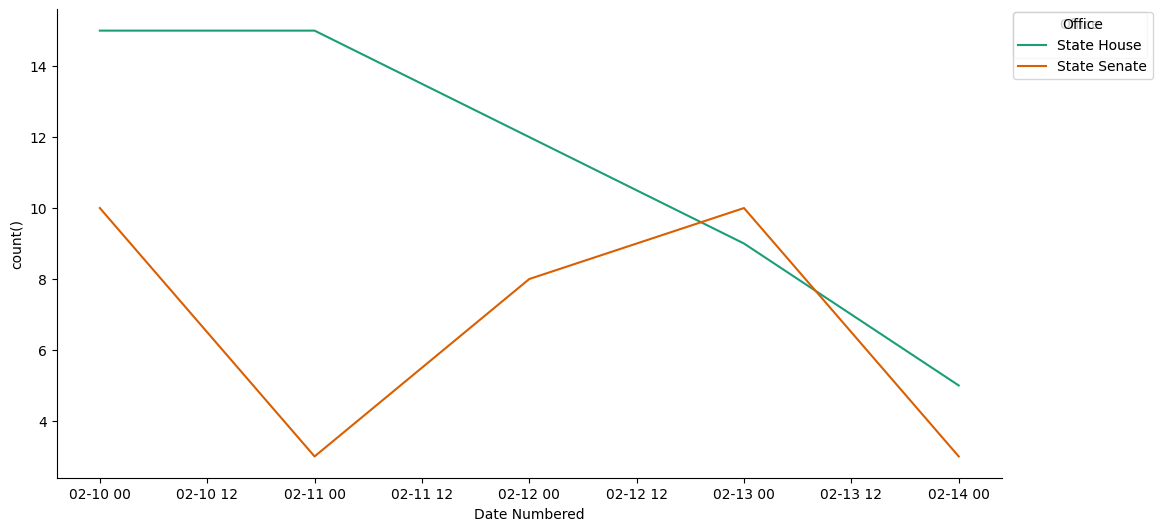

In [ ]:
# @title Date Numbered vs count()

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Date Numbered']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Date Numbered'}, axis=1)
              .sort_values('Date Numbered', ascending=True))
  xs = counted['Date Numbered']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = new_bills.sort_values('Date Numbered', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Office')):
  _plot_series(series, series_name, i)
  fig.legend(title='Office', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Date Numbered')
_ = plt.ylabel('count()')

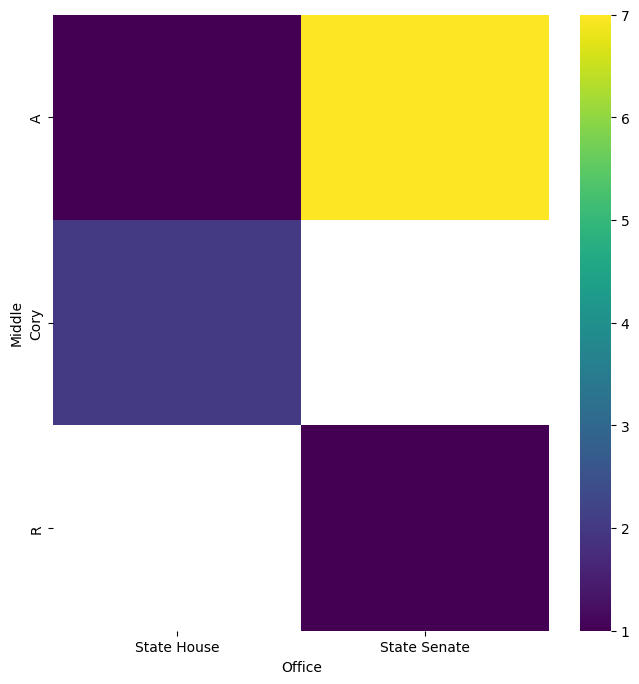

In [ ]:
# @title Office vs Middle

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Middle'].value_counts()
    for x_label, grp in new_bills.groupby('Office')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Office')
_ = plt.ylabel('Middle')

In [ ]:
passed_bills

,Bill Number,Bill Title,Bill Sponsor,Date Passed,Effective Date,Governor's Action,Gov's Action Date,Laws of Utah Chapter,filename,file_date
0,HB0001,Higher Education Base Budget,"Peterson, K.",2025-01-30,2025-07-01,NaN,NaN,NaN,passedBills_02142025.csv,2025-02-14
1,HB0004,Economic and Community Development Base Budget,"Watkins, C.",2025-01-30,2025-07-01,NaN,NaN,NaN,passedBills_02142025.csv,2025-02-14
2,HB0005,General Government Base Budget,"Thurston, N.",2025-01-30,2025-07-01,NaN,NaN,NaN,passedBills_02142025.csv,2025-02-14
3,HB0006,Transportation and Infrastructure Base Budget,"Welton, D.",2025-01-30,2025-07-01,NaN,NaN,NaN,passedBills_02142025.csv,2025-02-14
4,HB0007,"National Guard, Veterans Affairs, and Legislat...","Peterson, V.",2025-01-30,2025-07-01,NaN,NaN,NaN,passedBills_02142025.csv,2025-02-14
...,...,...,...,...,...,...,...,...,...,...
1059,SJR006,Joint Resolution Supporting State Jurisdiction...,"Harper, W.",2025-03-06,NaT,NaN,NaN,NaN,passedBills_03102025.csv,2025-03-10
1060,SJR007S01,Joint Resolution Emphasizing State Authority i...,"Cullimore, K. A.",2025-03-06,NaT,NaN,NaN,NaN,passedBills_03102025.csv,2025-03-10
1061,SJR009S01,Joint Resolution Amending Rules of Civil Proce...,"Brammer, B.",2025-03-07,NaT,NaN,NaN,NaN,passedBills_03102025.csv,2025-03-10
1062,SJR010S01,Joint Resolution Amending Court Rules Regardin...,"Pitcher, S.",2025-03-07,NaT,NaN,NaN,NaN,passedBills_03102025.csv,2025-03-10


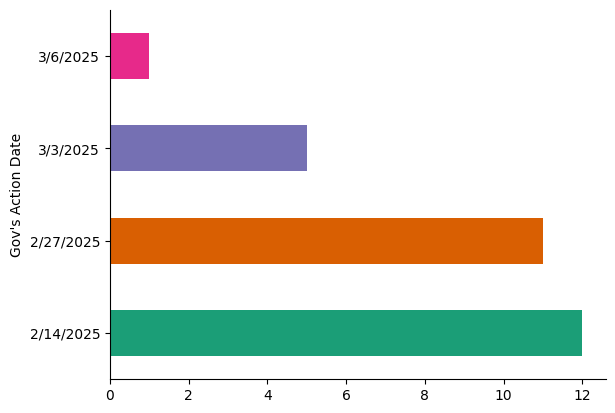

In [ ]:
# @title Gov's Action Date

from matplotlib import pyplot as plt
import seaborn as sns
passed_bills.groupby("Gov's Action Date").size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

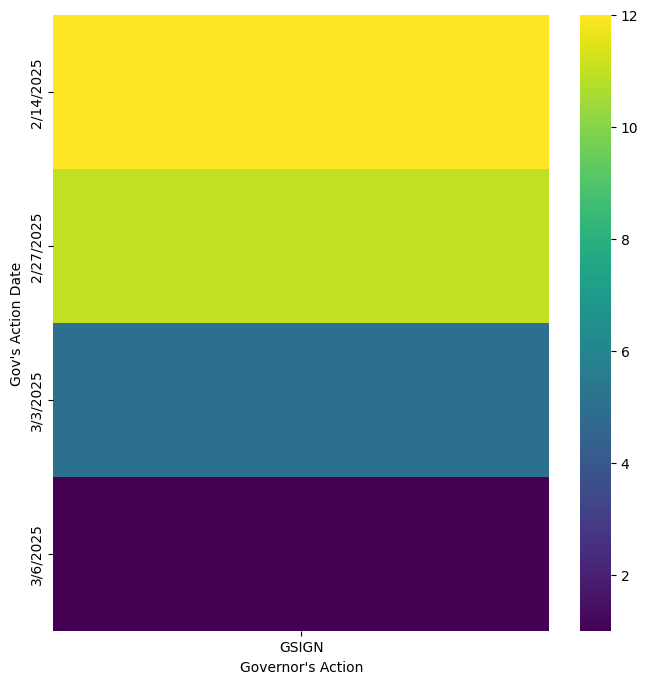

In [ ]:
# @title Governor's Action vs Gov's Action Date

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp["Gov's Action Date"].value_counts()
    for x_label, grp in passed_bills.groupby("Governor's Action")
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel("Governor's Action")
_ = plt.ylabel("Gov's Action Date")

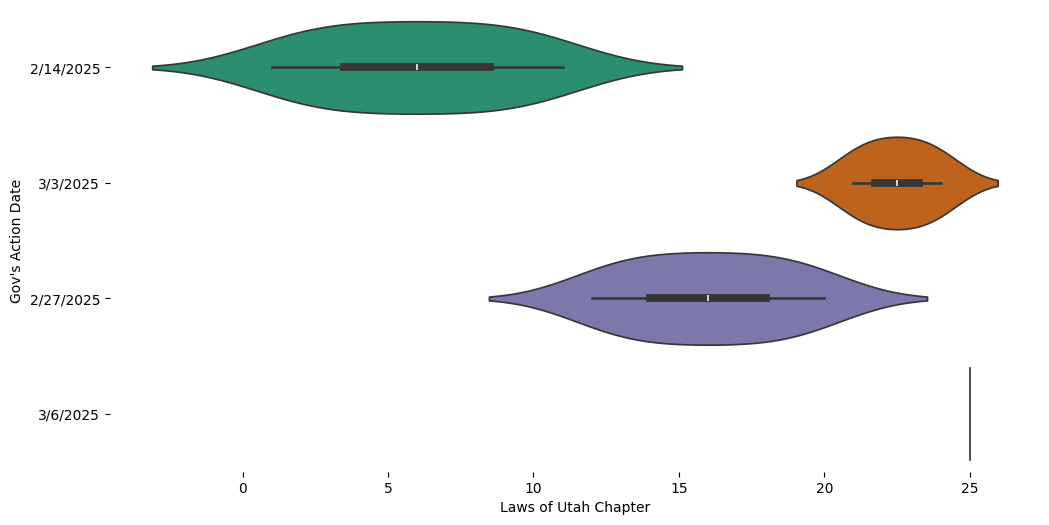

In [ ]:
# @title Gov's Action Date vs Laws of Utah Chapter

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(passed_bills["Gov's Action Date"].unique()))
plt.figure(figsize=figsize)
sns.violinplot(passed_bills, x='Laws of Utah Chapter', y="Gov's Action Date", inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [ ]:
# Now to pull in the bad_bills data